In [1]:
#import tigramite.independence_tests as it
#import tigramite.lpcmci as tg
import pandas as pd
import networkx as nx
#import importlib
#importlib.reload(tp)

import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline     

import tigramite
from tigramite import data_processing as dp #pp
#from tigramite.toymodels import structural_causal_processes as toys
from tigramite import plotting as tp
from tigramite.lpcmci import LPCMCI
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import CMIknn, GPDC #, GPDC, ParCorr, CMIsymb

import time
import dcor
from sklearn import gaussian_process

import pickle
import xarray as xr

/Users/Rebecca/anaconda/envs/py39/lib/python3.9/site-packages/tigramite/plotting.py:26: UserWarning: [Errno 2] No such file or directory: '../versions.py'
  warnings.warn(str(e))
/Users/Rebecca/anaconda/envs/py39/lib/python3.9/site-packages/tigramite/independence_tests/gpdc.py:27: UserWarning: [Errno 2] No such file or directory: '../versions.py'
  warnings.warn(str(e))
/Users/Rebecca/anaconda/envs/py39/lib/python3.9/site-packages/tigramite/independence_tests/gpdc_torch.py:33: UserWarning: No module named 'torch'
  warnings.warn(str(e))


In [ ]:
import inspect
inspect.signature(CMIknn)

In [ ]:
import sys
sys.path

In [ ]:
ls

In [2]:
fname = '~/Documents/MATLAB/MMM_Analysis/data/LPCMCI/csv/AWI_AWI-CM-1-1-MR_r1i1p1f1-TT.csv'
df = pd.read_csv (fname)
df.pop('SB')
df.pop('IN')
df.pop('Ph')
df.pop('L')
df_full = df.copy()
df_full_tg = dp.DataFrame(df.values, var_names = df.columns)
df.pop('GT')
df_tg = dp.DataFrame(df.values, var_names = df.columns)

In [ ]:
IT = CMIknn(knn=0.2, shuffle_neighbors=8)#GPDC(significance='analytic')#
M = LPCMCI(df_tg, IT, verbosity=1)
M_full = LPCMCI(df_full_tg, IT, verbosity = 1)

In [ ]:
t1 = time.time()
G_full = M_full.run_lpcmci(tau_max=5,n_preliminary_iterations=2)#tau_max=5, 
t2 = time.time()
elapsed = (t2-t1)/3600 #in hours
elapsed

In [ ]:
t1 = time.time()
G_no_GT = M.run_lpcmci()#tau_max=1, n_preliminary_iterations=2)#)
t2 = time.time()
elapsed = (t2-t1)/3600 #in hours
elapsed

In [ ]:
elapsed

In [ ]:
[b for b in df_full_tg.var_names[:-1] if not b in ['EN', 'AMM', 'GG']]


In [ ]:
seasons = {
    'W':['EN'],
    'Sp': ['GG', 'AMM'],
    'Su': [b for b in df_full_tg.var_names[:-1] if not b in ['EN', 'AMM', 'GG']]
}
seasons

In [ ]:
def edge(a,b,t):
    return (a, b, t)

def get_edge_and_val(edges_dict, i, e):
    return edges_dict.get(e[0]).get(e[1])[i][e[2]]

def get_edge(edges_dict, e):
    return get_edge_and_val(edges_dict,0,e)

def get_val(edges_dict, e):
    return get_edge_and_val(edges_dict,1,e)

def make_edges_dict(G, vals, V):
    return {
        V[i]:{
            V[j]:(G[i][j], vals[i][j]) for j in range(len(V))
        } for i in range(len(V))
    }

def make_score_dict(V):
    return {
        V[i]:{
            #anc, desc, conf
            V[j]:np.array([0,0,0]) for j in range(len(V))
        } for i in range(len(V))
    }

def get_score(score_dict, e):
    return score_dict.get(e[0]).get(e[1])[e[2]]

edge_points = {
    '-->':np.array([1,0,0]),
    '<--':np.array([0,1,0]),
    '<->':np.array([0,0,1]),
    'o->':np.array([2/3,0,1/3]),
    '<-o':np.array([0,2/3,1/3]),
    'o-o':np.array([1/3,1/3,1/3]),
    '':np.array([0,0,0])
}

#edges#{e:get_val(edges,e) for e in forbidden_edges}

In [ ]:
seasons = {
    'W':['EN'],
    'Sp': ['GG', 'AMM'],
    'Su': [b for b in df_full_tg.var_names[:-1] if not b in ['EN', 'AMM', 'GG']]
}

edge_scores = make_score_dict(df_full_tg.var_names[:-1])

forbidden_edges = [
    edge(a,b,0) for b in (seasons.get('Sp')+seasons.get('W')) for a in seasons.get('Su')] + [
    edge(a,b,0) for b in seasons.get('W') for a in seasons.get('Sp')
]
expected_edges = [
    edge('EN', 'Pc', 0), edge('Pc', 'EN', 1), #Pacific
    edge('GG', 'SA', 0), edge('SA', 'GG', 1), #South Atlantic
    edge('AMM', 'TA', 0), edge('TA', 'AMM', 1), #Tropical Atlantic
] + [edge(s, 'GT', 0) for s in ['Pc', 'SA', 'TA', 'SB', 'IN', 'Ph', 'L'] if s in seasons.get('Su')]
all_edges = [edge(a,b,i) for i in [0,1] for b in df_full_tg.var_names[:-1] for a in df_full_tg.var_names[:-1]]

Adj

In [ ]:
Adj = {e:np.array([0,0,0]) for e in all_edges}
n=0
edges = make_edges_dict(G_full['graph'], G_full['val_matrix'], df_full_tg.var_names[:-1])
if not '-->' in [get_edge(edges,e) for e in forbidden_edges]: #only completely directed edges are obviously non-physical
    if not any(['x' in get_edge(edges, e) for e in all_edges]):
        for e in all_edges:
            Adj.update({e:Adj.get(e)+edge_points.get(get_edge(edges, e))})
        n=n+1
Adj.update({e:Adj.get(e)/n for e in all_edges})
(Adj.get(expected_edges[3])+np.array([0,0,.1]))*np.array([0,1,1])+np.array([1,0,0])

In [ ]:
sum(sum(np.array([Adj.get(e) for e in all_edges])))

In [ ]:
[get_edge(edges,e) for e in expected_edges]+[get_edge(edges, edge('EN', 'Pc', 1))] 
#all edges that could include a direct causal relationship should be concluded

In [ ]:
np.array([1,0,0])+np.array([0,1,.3])

In [ ]:
#An edge structure will be the first
forbidden_edges = [
    (a, b, 0) for b in (seasons.get('Sp')+seasons.get('W')) for a in seasons.get('Su')
] + [
    (a, b, 0) for b in seasons.get('W') for a in seasons.get('Sp')
]

In [ ]:
'-->' in [get_edge(edges,e) for e in forbidden_edges]

In [ ]:
expected_edges = [
    ('')
]

tp.plot_graph(G['graph'], val_matrix=G['val_matrix'], var_names=df.columns, node_pos={'x':[4,2,3,5,1,2,3,1], 'y':[3,3,3,3,3,2,2,1]})

In [ ]:
x = [1,3,2,1,3,4,2.3,2,5,2]#,1[1,6,5,1,6,7,5,2,3,4,8]
L = len(x[3:])-2
x_end = [i-(L+1)/2 for i in x[3:]]
r = L
y_end = [((r**2-i**2)**.5 - r) for i in x_end]
y = np.array([3,2,2]+y_end)
y[-3] = -1
y[-1] = -2
#y[np.where((df.columns=='IN')|(df.columns=='L'))[0]]=y[np.where((df.columns=='IN')|(df.columns=='L'))[0]]+.5

In [ ]:
df_full_tg.var_names[:-1]


In [ ]:
#outside for loop
x_vals = {'NA':4, 'md':5}
x_vals.update(dict.fromkeys(['EN', 'Pc'],1)) #Pacific, Winter and Summer
x_vals.update(dict.fromkeys(['GG', 'SA'],2)) #South Atlantic, Spring and Summer
x_vals.update(dict.fromkeys(['AMM', 'TA'],3)) #Tropical Atlantic, Spring and Summer
x_vals.update(dict.fromkeys(['GT', 'pr'],2)) #extras
EXTRA = ['SB', 'IN', 'Ph', 'L'] #usually not included
x_vals.update({EXTRA[i]:(i+6) for i in range(len(EXTRA))})
y_vals = {'EN':5.5, 'GT':2, 'pr':1} #Winter and extras
y_vals.update(dict.fromkeys(seasons.get('Sp'),4.5)) #Spring
su_basins_full = ['Pc', 'SA', 'TA', 'NA', 'md', 'SB', 'IN', 'Ph', 'L']
#inside for loop
su_basins = [vn for vn in su_basins_full if vn in df_full_tg.var_names[:-1]]
r = len(su_basins)
y_vals.update({b:((r**2-(x_vals.get(b)-(r+1)/2)**2)**.5)-np.min([((3*r**2 + 2*r - 1)**.5)/2,r])+3 for b in su_basins})#
x = [x_vals.get(vn) for vn in df_full_tg.var_names[:-1]]
y = [y_vals.get(vn) for vn in df_full_tg.var_names[:-1]]
y

In [ ]:
su_basins_full = ['Pc', 'SA', 'TA', 'NA', 'md', 'SB', 'IN', 'Ph', 'L']


In [ ]:
model = 'TaiESM1'
P=tp.plot_graph(G_full['graph'], val_matrix=G_full['val_matrix'], var_names=df_full_tg.var_names[:-1], node_pos={'x':x, 'y':list(y)})#, arrow_linewidth=7)model = fname.replace('.','_').split('_')[3]
P[0].suptitle(model)
P[0].set_facecolor('lightgray')

In [ ]:
var = 'ts_pr'
knn = 2
p=1
tm = 1
SN=8
fn = model+'_'+var+'_SN'+str(SN)+'_knn'+str(knn)+'_p'+str(p)+'_tm'+str(tm)
P[0].savefig('Documents/MATLAB/MMM_Analysis/figures/LPCMCI/'+fn+'.png')


#new_name = 'Documents/MATLAB/MMM_Analysis/figures/LPCMCI/'+model+'_ts_SN8_knn1.png'
#P[0].savefig(new_name)

In [ ]:
df_full_tg.var_names

In [ ]:
#the edge will always be (r-1)/2. 


In [ ]:
L/2

In [ ]:
df_full

In [ ]:
import pickle
fl = open('Documents/MATLAB/MMM_Analysis/data/LPCMCI_graphs/'+fn+'.pkl', 'wb')
pickle.dump(G_full, fl)
fl.close()

In [ ]:
ls Documents/MATLAB/MMM_Analysis/data/LPCMCI_graphs/

In [ ]:
fl = open('Documents/MATLAB/MMM_Analysis/figures/LPCMCI/Ginsburg/scores.pkl', 'rb')
scores = pickle.load(fl)
fl.close()
scores

In [ ]:
scores.loc[(scores.index.get_level_values('p')=='1') & 
           (scores.index.get_level_values('tm')=='1') 
          ]

In [ ]:
S = xr.Dataset.from_dataframe(scores.droplevel('file')).astype('float')
S['strength'].max()

In [291]:
shape='p'
S[shape].values.max()

4

((0.35, 0.8), (0.35, 0.8))

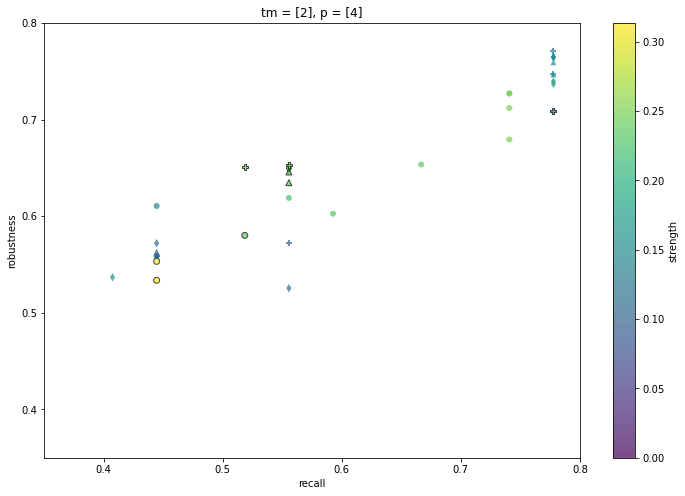

In [297]:
# how do my scores relate to each other? scatter plot with colors. 
#let's do recall vs robustness with strength as color.
#markers = {1:'o', 2:'d', 3:'^', 4:'s'} #or d

#there can only be 2 things for edge
def pltr(S, x, y, c, shape, edge): 
    markers = {1:'o', 2:'d', 3:'^', 4:'P', 5:'p', 6:'h', 7:'D', 8:'8', 9:'*', 10:'X'} #or d
    sizes = {(i,j):None for i in range(1,S[shape].values.max()+1) for j in range(1,S[edge].values.max()+1)}
    sizes.update({(1,1):8})
    add_guide = {i:False for i in range(2,max([S[shape].values.max(), S[edge].values.max()])+1)}
    add_guide.update({1:True})
    edge_colors = {1:'none', 2:'k'}
    for p in S[shape].values:
        for t in S[edge].values:
            S.isel({
                shape: S[shape]==p,
                edge:  S[edge]==t
            }).plot.scatter(
                x, y, hue=c, marker=markers.get(p), edgecolors=edge_colors.get(t),
                vmin=S[c].min(), vmax=S[c].max(), add_guide=add_guide.get(p)&add_guide.get(t), 
                alpha=.7, size=sizes.get((p,t))#, markersize='tm'
            )
    
pltr(S, 'recall', 'robustness', 'strength', 'p', 'tm')
plt.ylim([.35,.8]), plt.xlim([.35,.8])

#robustness and recall are highly corrolated. 
#But sometimes a boost to "robust" edges does overcome losses to recall of expected edges.
#The strength of expected edges is non-linearly related to recall and robustness.
#When tau_max=2 (black edges), recall tends to be lower (but one works well)
#For tau_max=1, increasing p can hurt or help (the only recall values between .6 and the max have p=1)
#For tau_max=2, it always helps, and p=4 gives a huge improvement over p=3


((0.05, 0.35), (0.5, 0.8))

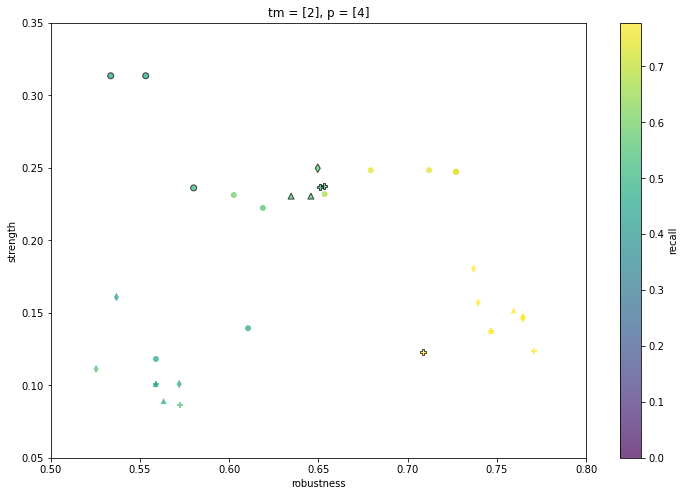

In [299]:
pltr(S, 'robustness', 'strength', 'recall', 'p', 'tm')
plt.ylim([.05,.35]), plt.xlim([.5,.8])

#recall tracks robustenss
#for tm=1, robustness and strength are non-linearly related; for tm=2, they are inversely related. 
#for both tm, strength is highest when p is low. 
#for tm=1, more preliminary iterations doesn't necessarily help (I'm not looking here at the CMIknn values....)
#for tm=2, it always helps.

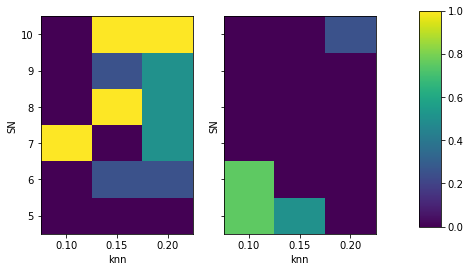

In [376]:
def CMIknn_comp(scorer):
    fig, ax = plt.subplots(1, 2, sharex='all', sharey='all')
    ts = S['tm'].values
    acb = {1:False, 2:True}
    for t in range(len(ts)):
        im = scorer.isel({
            'tm':   S['tm']==ts[t],
        }).mean(['p', 'tm']).plot(
            ax=ax[t], 
            vmin=(scorer>0).mean(['p']).min(), 
            vmax=(scorer>0).mean(['p']).max(),
            add_colorbar=False
        )  
    cbar_ax = fig.add_axes([1, 0.15, 0.05, .75])
    fig.colorbar(im, cax=cbar_ax)
    
CMIknn_comp(S['recall']>0)
#this graph shows the non-linear compensation between knn and SN, which could be expected!

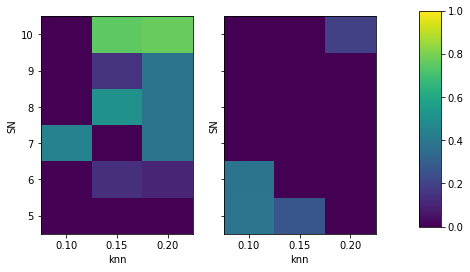

In [377]:
CMIknn_comp(S['recall'])
#recall and robustenss are better when both values are higher.
#because this maximizes at the top of the range, 
#it would seem it's possible that we should try larger values of knn and SN

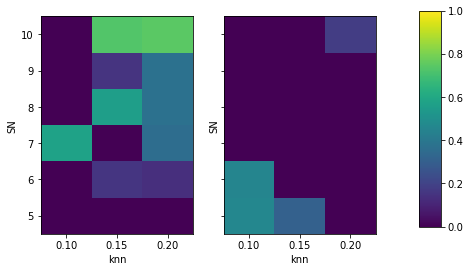

In [378]:
CMIknn_comp(S['robustness'])
#our metric prefers larger SN and knn. 
#larger SN decreases the size of the null distribution, increasing detection power (and false positives)
#larger knn reduces variance but increases bias.

In [ ]:
#p=2, knn=.2
#knn=.1 and SN=7, knn=.15 and SN=8, knn=.2 and SN=9,10
#p=1,2 and SN=7...10, p=3,4 and SN=10

#the summary of these things is p=2, knn=.2, SN=9,10
#This is not the graph with the best score, but maybe our scoring isn't the greatest. 

In [ ]:
G_full = {'graph': np.array([[['', ''],
         ['', ''],
         ['', ''],
         ['-->', 'o->'],
         ['', ''],
         ['', ''],
         ['', ''],
         ['', ''],
         ['', '']],
 
        [['', '-->'],
         ['', ''],
         ['', ''],
         ['', ''],
         ['-->', ''],
         ['', ''],
         ['', ''],
         ['-->', ''],
         ['', '']],
 
        [['', ''],
         ['', ''],
         ['', ''],
         ['', ''],
         ['', ''],
         ['', ''],
         ['-->', ''],
         ['', ''],
         ['', '']],
 
        [['<--', '-->'],
         ['', '-->'],
         ['', '-->'],
         ['', ''],
         ['', ''],
         ['<--', ''],
         ['', ''],
         ['-->', '-->'],
         ['', '']],
 
        [['', ''],
         ['<--', '-->'],
         ['', ''],
         ['', ''],
         ['', ''],
         ['-->', ''],
         ['', ''],
         ['', ''],
         ['', '']],
 
        [['', ''],
         ['', ''],
         ['', '-->'],
         ['-->', ''],
         ['<--', ''],
         ['', ''],
         ['', ''],
         ['', ''],
         ['', '']],
 
        [['', ''],
         ['', ''],
         ['<--', ''],
         ['', ''],
         ['', ''],
         ['', ''],
         ['', ''],
         ['-->', ''],
         ['', '']],
 
        [['', ''],
         ['<--', ''],
         ['', ''],
         ['<--', ''],
         ['', ''],
         ['', ''],
         ['<--', ''],
         ['', ''],
         ['', '']],
 
        [['', ''],
         ['', ''],
         ['', ''],
         ['', ''],
         ['', ''],
         ['', ''],
         ['', ''],
         ['', ''],
         ['', '']]], dtype='<U3'),
 'p_matrix': np.array([[[0.   , 0.07 ],
         [0.053, 0.11 ],
         [0.514, 0.078],
         [0.   , 0.033],
         [0.221, 0.628],
         [0.596, 0.204],
         [0.593, 0.803],
         [0.178, 0.094],
         [0.957, 0.976]],
 
        [[0.053, 0.012],
         [0.   , 0.893],
         [0.071, 0.081],
         [0.111, 0.132],
         [0.   , 0.141],
         [0.366, 0.192],
         [0.835, 0.8  ],
         [0.003, 0.768],
         [0.876, 0.44 ]],
 
        [[0.514, 0.914],
         [0.071, 0.655],
         [0.   , 0.353],
         [0.064, 0.356],
         [0.174, 0.178],
         [0.23 , 0.52 ],
         [0.   , 0.513],
         [0.104, 0.465],
         [0.738, 0.697]],
 
        [[0.   , 0.   ],
         [0.111, 0.   ],
         [0.064, 0.   ],
         [0.   , 0.522],
         [0.054, 0.813],
         [0.038, 0.156],
         [0.056, 0.519],
         [0.   , 0.   ],
         [0.293, 0.938]],
 
        [[0.221, 0.196],
         [0.   , 0.031],
         [0.174, 0.523],
         [0.054, 0.053],
         [0.   , 0.91 ],
         [0.   , 0.479],
         [0.863, 0.485],
         [0.498, 0.435],
         [0.818, 0.937]],
 
        [[0.596, 0.894],
         [0.366, 0.507],
         [0.23 , 0.035],
         [0.038, 0.685],
         [0.   , 0.435],
         [0.   , 0.659],
         [0.794, 0.649],
         [0.607, 0.376],
         [0.11 , 0.667]],
 
        [[0.593, 0.452],
         [0.835, 0.956],
         [0.   , 0.433],
         [0.056, 0.146],
         [0.863, 0.51 ],
         [0.794, 0.374],
         [0.   , 0.324],
         [0.022, 0.35 ],
         [0.529, 0.108]],
 
        [[0.178, 1.   ],
         [0.003, 0.361],
         [0.104, 0.104],
         [0.   , 0.086],
         [0.498, 0.754],
         [0.607, 0.492],
         [0.022, 0.657],
         [0.   , 0.081],
         [0.497, 0.936]],
 
        [[0.957, 0.294],
         [0.876, 0.457],
         [0.738, 0.349],
         [0.293, 0.66 ],
         [0.818, 0.546],
         [0.11 , 0.586],
         [0.529, 0.106],
         [0.497, 0.105],
         [0.   , 0.168]]]),
 'val_matrix': np.array([[[ 0.00000000e+00,  6.38257999e-03],
         [ 1.50415906e-02,  7.49977554e-03],
         [ 7.13040664e-03,  1.06698097e-02],
         [ 4.11681685e-02,  1.64656182e-02],
         [ 8.04975329e-03,  5.51587226e-03],
         [ 5.59385173e-03,  7.94397708e-03],
         [ 5.37395187e-03, -4.06633589e-04],
         [ 1.62291832e-02,  9.66963763e-03],
         [ 4.56501052e-03, -2.93349053e-03]],
 
        [[ 1.50415906e-02,  6.82307037e-03],
         [ 0.00000000e+00,  2.90596512e-03],
         [ 1.69266090e-02,  9.79603241e-03],
         [ 7.83571543e-03,  9.16411919e-03],
         [ 4.82437360e-01,  7.76573517e-03],
         [ 4.06520370e-03,  7.01650885e-03],
         [ 3.88417756e-03,  2.07394685e-03],
         [ 1.36566212e-02,  2.16192041e-03],
         [ 2.29907341e-04,  4.76156070e-03]],
 
        [[ 7.13040664e-03,  2.60797403e-03],
         [ 1.69266090e-02,  2.38568954e-03],
         [ 0.00000000e+00,  6.56734606e-03],
         [ 1.03562453e-02,  5.12710949e-03],
         [ 5.11015699e-03,  7.88034539e-03],
         [ 7.84419144e-03,  5.96784393e-03],
         [ 5.89045847e-01,  3.55880506e-03],
         [ 8.89136261e-03,  5.24240093e-03],
         [ 1.73865841e-03,  2.28650627e-03]],
 
        [[ 4.11681685e-02,  7.43847487e-01],
         [ 7.83571543e-03,  2.39178245e-01],
         [ 1.03562453e-02,  1.28658769e-01],
         [ 0.00000000e+00,  5.16665811e-03],
         [ 9.14253868e-03,  1.35385494e-03],
         [ 1.47511935e-02,  9.59318145e-03],
         [ 9.86489132e-03,  5.71837825e-03],
         [ 2.22221410e-01,  1.12686493e-01],
         [ 7.69977015e-03,  2.93486928e-04]],
 
        [[ 8.04975329e-03,  5.71581857e-03],
         [ 4.82437360e-01,  1.33960567e-02],
         [ 5.11015699e-03,  4.21311745e-03],
         [ 9.14253868e-03,  1.18120240e-02],
         [ 0.00000000e+00,  1.86880689e-03],
         [ 6.55839024e-02,  5.51875548e-03],
         [ 2.62670863e-03,  5.55085065e-03],
         [ 6.93814427e-03,  6.36322812e-03],
         [ 1.03203393e-03,  3.42469469e-04]],
 
        [[ 5.59385173e-03,  1.63093948e-03],
         [ 4.06520370e-03,  4.06725967e-03],
         [ 7.84419144e-03,  1.40776094e-02],
         [ 1.47511935e-02,  4.25064890e-03],
         [ 6.55839024e-02,  5.57895970e-03],
         [ 0.00000000e+00,  4.07909645e-03],
         [ 3.83367209e-03,  3.56628646e-03],
         [ 5.80784167e-03,  5.86403813e-03],
         [ 8.96976032e-03,  4.57121494e-03]],
 
        [[ 5.37395187e-03,  4.63495782e-03],
         [ 3.88417756e-03, -4.70289533e-04],
         [ 5.89045847e-01,  6.76280169e-03],
         [ 9.86489132e-03,  1.11601937e-02],
         [ 2.62670863e-03,  4.52104449e-03],
         [ 3.83367209e-03,  5.81882588e-03],
         [ 0.00000000e+00,  4.26218362e-03],
         [ 1.49102428e-02,  4.24135801e-03],
         [ 3.36738894e-03,  7.70469811e-03]],
 
        [[ 1.62291832e-02, -3.05433864e-02],
         [ 1.36566212e-02,  1.28254061e-02],
         [ 8.89136261e-03,  9.15702486e-03],
         [ 2.22221410e-01,  7.02889883e-03],
         [ 6.93814427e-03,  1.12822529e-03],
         [ 5.80784167e-03,  4.52462571e-03],
         [ 1.49102428e-02,  3.56230969e-03],
         [ 0.00000000e+00,  8.14551759e-03],
         [ 6.27322883e-03,  4.62186872e-04]],
 
        [[ 4.56501052e-03,  3.50534884e-03],
         [ 2.29907341e-04,  4.24048730e-03],
         [ 1.73865841e-03,  4.82613850e-03],
         [ 7.69977015e-03,  5.64582344e-03],
         [ 1.03203393e-03,  5.77830247e-03],
         [ 8.96976032e-03,  4.16929778e-03],
         [ 3.36738894e-03,  7.71661547e-03],
         [ 6.27322883e-03,  6.42499218e-03],
         [ 0.00000000e+00,  8.71832378e-03]]])}
G_full